IMPORT LIBRARIES

In [170]:
import numpy as np 
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

READ THE DATA:

- In this challenge you will use the dataset Titanic disaster.
- With the following lines of code, you can import the dataset form the file "train.csv", extract te column of labels (column "Survived") and read the infos of the other features.

---



In [172]:
# Read the dataset
features, labels = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Split the dataset and analyse only the training set to avoid biases
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, stratify=labels, test_size=0.2, random_state=42)

Visualize the first rows

In [173]:
X_train.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0.0,0.0,383123,7.7500,None,Q,15 16,NaN,None
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1.0,0.0,SC/PARIS 2167,27.7208,None,C,12,NaN,"Lucca, Italy / California"


Check if there are missing values in the dataframe

In [174]:
X_train.isnull().any()

pclass       False
name         False
sex          False
age           True
sibsp        False
parch        False
ticket       False
fare          True
cabin         True
embarked     False
boat          True
body          True
home.dest     True
dtype: bool

We can see that *age, fare, cabin, boat, body, home.dest* have missing values. Let's determine how many

In [175]:
(X_train.isnull().sum()/X_train.shape[0])*100

pclass        0.000000
name          0.000000
sex           0.000000
age          19.961796
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.095511
cabin        78.510029
embarked      0.000000
boat         62.846227
body         91.212989
home.dest    42.979943
dtype: float64

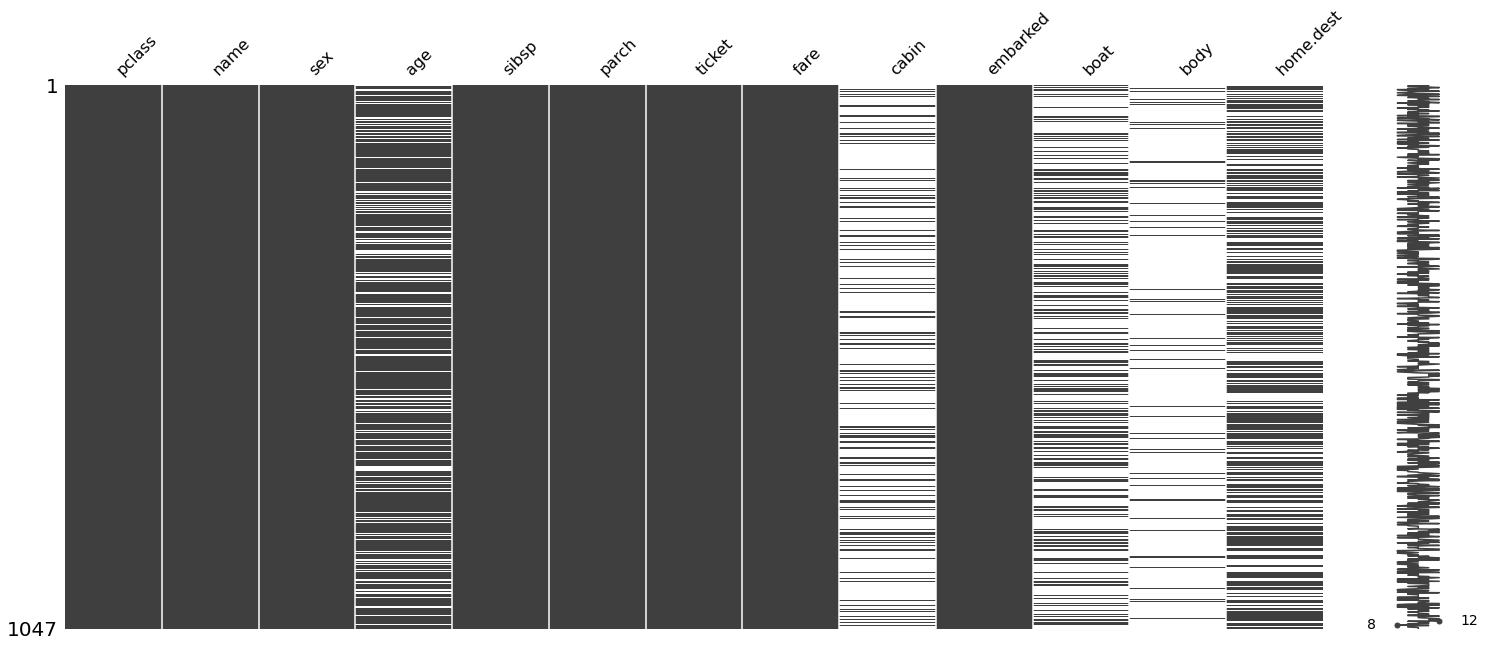

In [176]:
msno.matrix(X_train)
plt.show()

We can see that cabin, body, boat, are very corrupted (78%, 62%, 91% missing respectively) so it may be wise to just ignore those features. The home.dest columns is also very corrupted and it's practically not possible to imputate those values based on the data from the other passagers and from the other columns, so it will be also ignored.

Also from here we see that for the age and fare features wee will need to perform imputation.

In [177]:
X_train.drop(columns=['cabin', 'boat', 'body', 'home.dest'], inplace=True)
X_test.drop(columns=['cabin', 'boat', 'body', 'home.dest'], inplace=True)

For the remaining columns lets go in detail

In [178]:
X_train.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0.0,0.0,383123,7.7500,Q
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1.0,0.0,SC/PARIS 2167,27.7208,C


Name

In [179]:
X_train.name.sample(10)

1041                                  Murdlin, Mr. Joseph
965                                Lievens, Mr. Rene Aime
260                             Shutes, Miss. Elizabeth W
449                 Hocking, Mrs. Elizabeth (Eliza Needs)
730                                         Cor, Mr. Ivan
212                                 Natsch, Mr. Charles H
589     Wells, Mrs. Arthur Henry ('Addie' Dart Trevaskis)
1220                              Spinner, Mr. Henry John
740                                   Culumovic, Mr. Jeso
196                                  Marechal, Mr. Pierre
Name: name, dtype: object

Is interesting to see that in the name there is information of the marital/social status encoded in teh Mr. Mrs. Master. etc. That could be useful

Class

In [180]:
X_train.pclass.unique()

array([3., 2., 1.])

In [181]:
X_train['pclass'] = X_train.pclass.astype(int)
X_test['pclass'] = X_test.pclass.astype(int)

Sex

In [182]:
X_train.sex.value_counts()

male      675
female    372
Name: sex, dtype: int64

We can see an unbalanced dataset with more men than female

Age

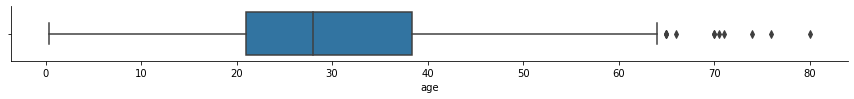

In [183]:
plt.figure(figsize=(15,1))
sns.boxplot(x=X_train.age)
sns.despine()
plt.show()

We can see no impossible/wrongly entered values in age (age<0, age>100)

Sibsp

In [184]:
X_train.sibsp.value_counts()

0.0    725
1.0    242
2.0     32
4.0     20
3.0     17
5.0      6
8.0      5
Name: sibsp, dtype: int64

Parch

In [185]:
X_train.parch.value_counts()

0.0    802
1.0    131
2.0     95
3.0      8
5.0      5
4.0      4
9.0      2
Name: parch, dtype: int64

Ticket

In [186]:
X_train.ticket.dtype

dtype('O')

The ticket column don't seem to have useful information. It will be dropped.

In [187]:
X_train.drop(columns=['ticket'], inplace=True)
X_test.drop(columns=['ticket'], inplace=True)

Fare

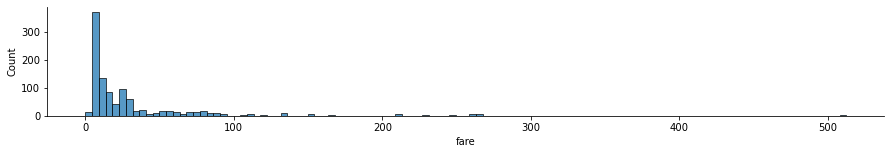

In [188]:
plt.figure(figsize=(15,2))
sns.histplot(data=X_train, x='fare')
sns.despine()
plt.show()

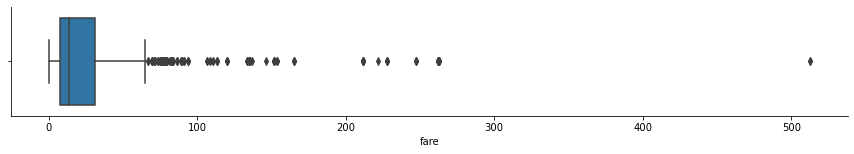

In [189]:
plt.figure(figsize=(15,2))
sns.boxplot(data=X_train, x='fare')
sns.despine()
plt.show()

Here we can see that maybe the fare over 500 is a mistake, our someone got scammed XD

Embarked

In [190]:
X_train.embarked.value_counts()

S    730
C    214
Q    103
Name: embarked, dtype: int64

Lets analyse the correlation between features

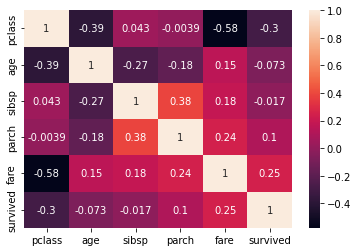

In [191]:
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(
    X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
    annot=True
)

From here we can get some important elements:
- The Class of the passenger is inversely correlated with the survival, passengers in the third class had less changes to survive.
- The Age is not correlated with survival
- Sibsp and Parch, both features indicating familiar status of the passager are correlated.
- The fare is positively correlated with the survival rate as (sadly) expected.

### Feature Engineering

- Evaluate if there are features with missing values and modify them (see https://scikit-learn.org/stable/modules/impute.html)
- Find meaningful features (some features are not needed because do not contain useful infos)
- Encode categorical features with numerical values (see https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features)

Lets get the title out of the name and combine parch and sibs in a family feature. Since the new family feature will be highly correlated with the other two and also contain them,  parch and sibl will be dropped. In the case of the name, we will retain just the title.

In [192]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['is_alone'] = True
    dataset.loc[dataset['family_size'] > 1, 'is_alone'] = False
    dataset['title'] =  dataset['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset.drop(["name"], axis=1, inplace=True)
X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
999,3,female,NaN,7.7500,Q,0.0,True,Miss
392,2,female,24.0,27.7208,C,1.0,True,Mrs
628,3,female,11.0,31.2750,S,6.0,False,Miss
1165,3,male,25.0,7.2250,C,0.0,True,Mr
604,3,female,16.0,7.6500,S,0.0,True,Miss


In [193]:
X_train.title.value_counts()

Mr              606
Miss            210
Mrs             156
Master           51
Rev               6
Dr                6
Col               3
Mlle              2
Ms                2
Major             1
Don               1
the Countess      1
Capt              1
Dona              1
Name: title, dtype: int64

There are many titles,lets group them.

In [194]:
pd.crosstab(X_train['title'], X_train['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,3
Don,0,1
Dona,1,0
Dr,0,6
Major,0,1
Master,0,51
Miss,210,0
Mlle,2,0


In [195]:
print(f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}")
print(f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}")

Miss: 0.13371537726838587
Mrs: 0.1174785100286533


The difference between Miss and Mrs seems to be insignificant, group them together in one. Lets also group all the rare titles.

In [196]:
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

Mr              False
Miss            False
Mrs             False
Master          False
Rev              True
Dr               True
Col              True
Ms               True
Major            True
Mlle             True
Don              True
the Countess     True
Capt             True
Dona             True
Lady             True
Mme              True
Sir              True
Jonkheer         True
Name: title, dtype: bool

In [197]:
for dataset in [X_train, X_test]:
    dataset.loc[dataset.title == 'Miss', 'title'] = 'Mrs'
    dataset['title'] = dataset.title.apply(lambda x: 'rare' if rare_titles[x] else x)

### Imputation

We can work separetely categorical and cuantitative features

Categorical:

In [198]:
def get_cat_cols(df):
    obj_cols = df.columns[df.dtypes == 'object']
    cat_cols = df.columns[df.dtypes == 'category']
    return set(obj_cols).union(set(cat_cols))

cat_cols = get_cat_cols(X_train)
cat_cols

{'embarked', 'sex', 'title'}

Even if in the training data we didn't find any missing value for the categorical variables in the test set they might be, so we consider the case in the transformer pipeline, using "most frequent strategy". We are going to transform the categorical variables into numeric ones to enlarge the spectrum of models we can use. After using one hot encoding, PCA transformation is used in order to reduce the dimensionality of the complete categorical encodings and retain the combined features that explain the most of the variability of the data.

In [199]:
cat_cols = ['embarked', 'sex', 'pclass', 'title', 'is_alone']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=10))
])

Numerical

We will perfom the inputation with knn of 5 neighbours. Since we have seen that our numerical variables have several outliers, we can Scale and Standarize these variables considering median and iqr in order no to use biased central position estimators.

In [200]:
num_cols = ['age', 'fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

Combined pipeline

In [201]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

### Model selection

TRAIN AND TEST DIFFERENT CLASSIFIERS:

- Find the best parameters for each classifier with a stratified 10-fold cross validation (see https://scikit-learn.org/stable/modules/cross_validation.html)

- Try these models:

>- Naive Bayes (see https://scikit-learn.org/stable/modules/naive_bayes.html) 
>- kNN (see https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
>- Decision tree (see https://scikit-learn.org/stable/modules/tree.html)
>- Logistic regression (see https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

- Show the final performances in terms of accuracy 

In [257]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [216]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', "passthrough")])

In [253]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

classifier_dist_1 = {
    'classifier': [GaussianNB()],
}
classifier_dist_2 = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': list(range(50, 500)),
    'classifier__max_depth': list(range(2, 20)),
    'classifier__bootstrap': [True, False],
}
classifier_dist_3 = {
    'classifier': [NearestNeighbors()],
    'classifier__n_neighbors': list(range(5, 35)), # 35 ~ sqrt(len(train_set))
    'classifier__size': [1,20,40],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev']
}
classifier_dist_4 = {
    'classifier': [DecisionTreeClassifier()],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': list(range(5, 20))+[None],
    'classifier__max_features':['auto', 'sqrt', 'log2', None],
}

param_dist = {**num_transformer_dist,
              **cat_transformer_dist, 
              **classifier_dist_1, 
              **classifier_dist_2,
              **classifier_dist_3,
              **classifier_dist_4}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    scoring='accuracy', n_iter=100, cv=10
)

In [254]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'fare',
                                                                                'family_size']),
                                                                              ('cat',
                             

In [259]:
scores = random_search.best_estimator_.predict(X_test)
print('\nPrediction accuracy:')
print('{:.2%}\n'.format(accuracy_score(y_test, scores)))


Prediction accuracy:
79.77%

